<a href="https://colab.research.google.com/github/Pramod560/kagglecompetition/blob/master/cats_or_dogs_with_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""install kaggle to download dataset"""
!pip install kaggle

In [2]:
#upload kaggle.json(Kaggle API token) file to 
#allow download dataset with your kaggle account credential
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pramod560","key":"3b1c3939d9c917e2bc29d2e2564f1aab"}'}

In [0]:
""" create kaggle directory and copy kaggle.json on that directory"""
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [0]:
"""change access permissions."""
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
"""download dogs-cats-images data from kaggle using dataset download api.""" 
!kaggle datasets download -d chetankv/dogs-cats-images

100% 433M/435M [00:09<00:00, 57.4MB/s]
100% 435M/435M [00:09<00:00, 48.9MB/s]


In [6]:
"""
extract zip file of dataset usin zipfile module.
step-1: first we import zipfile.ZipFile the module.
step-2: open zip file with reading mode as a zip.
step-3: extract zip file using extractall() method.
"""
import zipfile
zip_ref = zipfile.ZipFile("dogs-cats-images.zip", "r")
zip_ref.extractall()
zip_ref.close()
print("done")

done


In [0]:
"""
create two variables to store the directory name of our training and testing data
"""
train_dir = "dataset/training_set"
test_dir = "dataset/test_set"

In [8]:
"""
we use glob module to fetch filename from directory,
and count how many images we have to train and test,
our model.
"""
from glob import glob

train_dogs = 0
test_dogs = 0
train_cats = 0
test_cats = 0
for i in glob("dataset/training_set/dogs/*.jpg"):
  train_dogs += 1
for i in glob("dataset/training_set/cats/*.jpg"):
  train_cats += 1
for i in glob("dataset/test_set/dogs/*.jpg"):
  test_dogs += 1
for i in glob("dataset/test_set/cats/*.jpg"):
  test_cats += 1

print(train_dogs)
print(train_cats)
print(test_dogs)
print(test_cats)


4000
4000
1000
1000


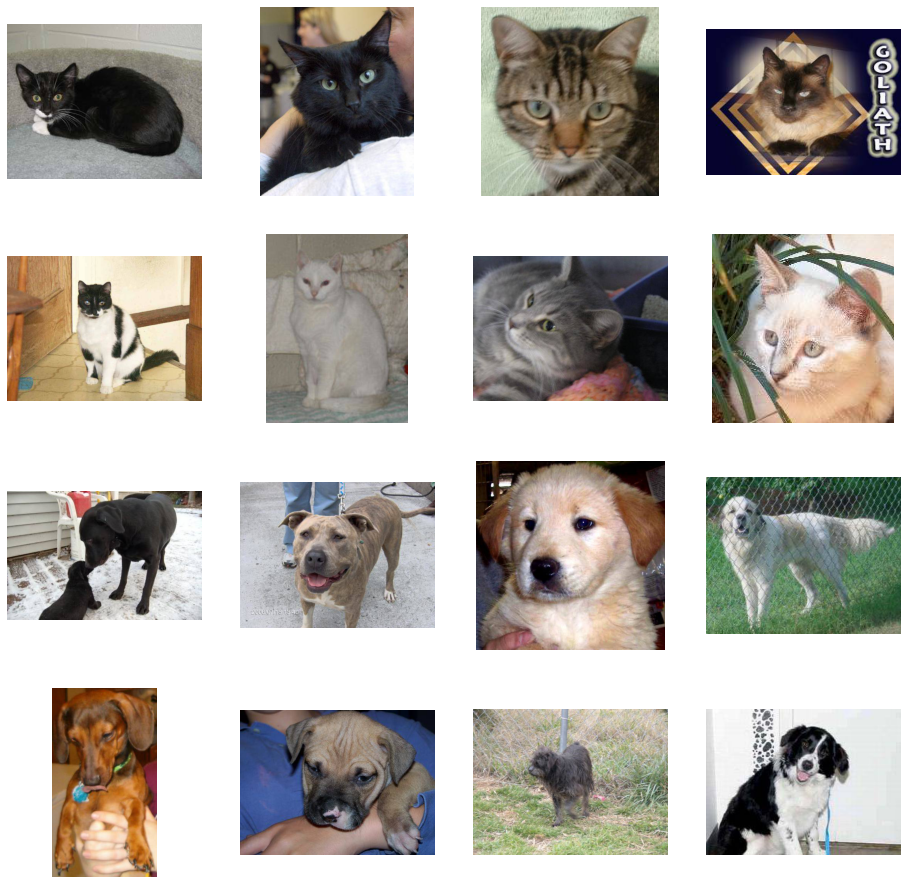

In [9]:
"""
we use matplotlib to see some images from our dataset.
"""
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# parameter for our graph.
nrows = 4
ncols = 4



#set up matplotlib fig.
fig = plt.gcf()
#set size which fit for 4x4.
fig.set_size_inches(nrows*4 , ncols*4)


#get cats & dogs filename in list.
cats = [cat for cat in glob("dataset/training_set/cats/*.jpg")[:64:8]]
dogs = [dog for dog in glob("dataset/training_set/dogs/*.jpg")[:64:8]]


for i, img_path in enumerate(cats+dogs):
  #set up subplot: subplot indices stats from 1.
  sp = plt.subplot(nrows, ncols, i+1)
  #don't show axis or gridlines.
  sp.axis("off")
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [0]:
import tensorflow as tf
#create myCallback class with function on_epoch_end 
#if we reach at accuracy 0.8 then our training is stoped in middle
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get("val_accuracy")>=0.80):
      self.model.stop_training = True

In [18]:
###DATA AUGMENTATION###
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#use tensorflow.keras.preprocessing.image.ImageDataGenerator to augument training or testing data 
#to stop overfitting 
train_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    rotation_range = 40,   
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest"
)
validation_datagen = ImageDataGenerator(
    rescale = 1./255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",

)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = "binary"
)
validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size = (256,256),
    batch_size = 32,
    class_mode = "binary"
)


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [19]:
import tensorflow as tf
from tensorflow import keras

#create cnn with 3 Convolution layer, 1 dense and output layer
#then compile our model 
#and print summary of our model


model = tf.keras.models.Sequential([
                    tf.keras.layers.Conv2D(16,(3,3), activation = "relu", input_shape=(256,256,3)),
                    tf.keras.layers.MaxPooling2D(2,2),
                    tf.keras.layers.Conv2D(32,(3,3), activation = "relu"),
                    tf.keras.layers.MaxPooling2D(2,2),
                    tf.keras.layers.Conv2D(64,(3,3), activation = "relu"),
                    tf.keras.layers.MaxPooling2D(2,2),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(512,activation = "relu"),
                    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 57600)            

In [20]:
#train our model with training data with 10 epoch
callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    epochs = 10,
    #steps_per_epoch=100,
    validation_data = validation_generator,
    #validation_steps=100,
    callbacks=[callbacks],
    verbose=1
)

Epoch 1/10
250/250 [==============================] - 152s 610ms/step - loss: 0.8413 - accuracy: 0.5795 - val_loss: 0.6813 - val_accuracy: 0.5820
Epoch 2/10
250/250 [==============================] - 152s 608ms/step - loss: 0.6466 - accuracy: 0.6357 - val_loss: 0.6552 - val_accuracy: 0.6195
Epoch 3/10
250/250 [==============================] - 151s 604ms/step - loss: 0.6145 - accuracy: 0.6687 - val_loss: 0.7122 - val_accuracy: 0.6150
Epoch 4/10
250/250 [==============================] - 151s 604ms/step - loss: 0.5988 - accuracy: 0.6829 - val_loss: 0.5802 - val_accuracy: 0.6865
Epoch 5/10
250/250 [==============================] - 151s 604ms/step - loss: 0.5776 - accuracy: 0.6967 - val_loss: 0.6324 - val_accuracy: 0.6695
Epoch 6/10
250/250 [==============================] - 150s 602ms/step - loss: 0.5691 - accuracy: 0.7096 - val_loss: 0.5733 - val_accuracy: 0.6930
Epoch 7/10
250/250 [==============================] - 150s 600ms/step - loss: 0.5511 - accuracy: 0.7203 - val_loss: 0.6489 -

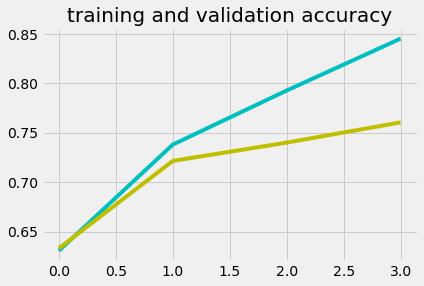

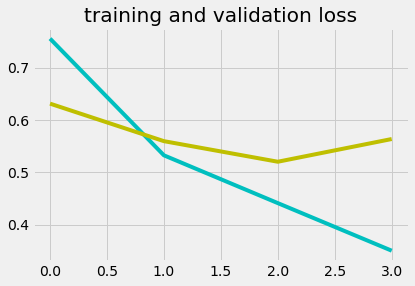

In [14]:
#plot graph between trianing loss and val_loss
#also plot graph between training accuracy and val_accuracy

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epoch = range(len(accuracy))
plt.plot(epoch, accuracy, "c-")
plt.plot(epoch, val_accuracy, "y-")
plt.title("training and validation accuracy")
plt.figure()
plt.plot(epoch, loss, "c-")
plt.plot(epoch, val_loss, "y-")
plt.title("training and validation loss")
plt.grid("off")
plt.show()




In [21]:
#predict labels cats or dogs for given images
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  img = image.load_img(fn, target_size=(256,256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if (classes>0):
    print(fn +" is a dog")
  else:
    print(fn +" is a cat")

Saving Screenshot from 2020-05-25 14-54-35.png to Screenshot from 2020-05-25 14-54-35.png
Saving Screenshot from 2020-05-25 14-54-19.png to Screenshot from 2020-05-25 14-54-19.png
[1.]
Screenshot from 2020-05-25 14-54-35.png is a dog
[1.]
Screenshot from 2020-05-25 14-54-19.png is a dog


In [0]:
def zipper(x, y):
  size = len(x) if len(x) <= len(y) else len(y)
  retList = []
  for i in range(size):
    retList.append((x[i], y[i]))
  return retList

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


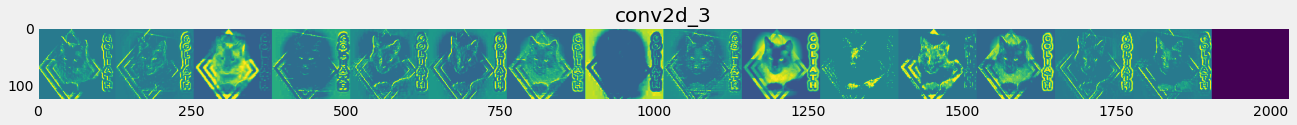

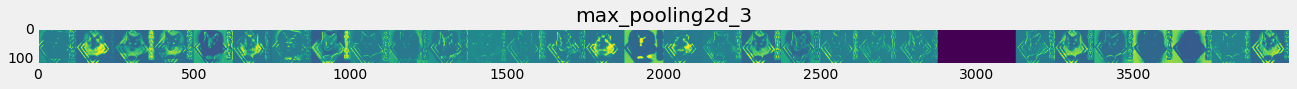

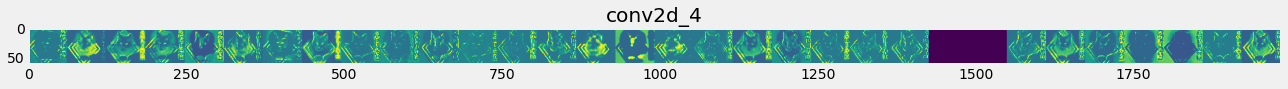

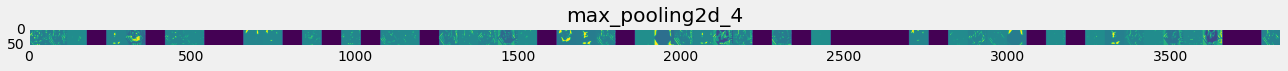

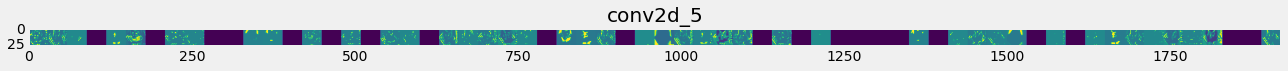

In [23]:
#visualizing the effect of convolution on image 
#and print the resulted image of each convolution layer
import tensorflow as tf
from glob import glob
import numpy as np
#from itertools import izip
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#define a new model that takes image as a imput and will output the
#intermediate representation of each layer in the above model 

succesive_model = [layer.output for layer in model.layers[1:]]

#visualization model = Model(img_input, succesive_model)
visualization_model = tf.keras.models.Model(inputs= model.inputs, outputs=succesive_model)

#lets prepare a random image from training images
cats = [cat for cat in glob("dataset/training_set/cats/*.jpg")[:64:8]]
dogs = [dog for dog in glob("dataset/training_set/dogs/*.jpg")[:64:8]]
img_path= random.choice(cats+dogs)

#load image 
img = load_img(img_path, target_size=(256,256))
x = img_to_array(img)
x = x.reshape((1,)+x.shape)

#rescale
x /= 255.0

#lets run our image through our network
succesive_image_map = visualization_model.predict(x)

#get layers name
layers_name = [layer.name for layer in model.layers]

#now display our representation
for layer_name, feature_map in zipper(layers_name, succesive_image_map):
  if len(feature_map.shape) == 4:
    #just do this for conv/maxpool layer not for fully connected layer
    #number of feature in feature_map
    n_features = feature_map.shape[-1] 
    #the feature map has shape(1,size,size,n_features)
    size = feature_map.shape[1]
    #we will tile our image in this matrics
    display_grid = np.zeros((size, size*n_features))

    for i in range(n_features):
      #postprocess the feature to make it visually palatable
      x = feature_map[0,:,:,i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x,0,255).astype(np.uint8)
      #we will tile each filter in this big horizontal filter
      display_grid[:,i*size:(i+1)*size] = x
    scale = 20./n_features
    #display the grid
    plt.figure(figsize  = (scale*n_features, scale)) 
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect="auto", cmap="viridis")
    plt.show()